# AST image processing with Python

This notebook shows an example using the Antibiotic Susceptibility Test (AST) image processing python module.

This module allows the automatic analysis of disk diffusion AST pictures.

The analysis can be carried out step-by-step with the dedicated functions or directly by using the `astimp.AST` class.


The AST image processing code can be downloaded from [Github](https://github.com/mpascucci/AST-image-processing).

Description and installation of the python module are available in the main [README](https://github.com/mpascucci/AST-image-processing/blob/master/README.md).

In [1]:
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astimp
import astimp_tools
draw = astimp_tools.draw

%matplotlib inline

img_path = "../../tests/images/test0.jpg"

# Parameter configuration

The image processing parameters are stored in `astimp.config` .

They can be displayed and set as normal python variables and will affect the analysis at run time.

Most parameters are optimized and should not be modified.

Users might want to change the antibiotic disk diameter, which is by default 6mm.

In [2]:
# Print the real diameter of the antibiotic disks in millimeters
# This parameter is used to get the scale of the image

print("Antibiotic disk diameter:", astimp.config.Pellets_DiamInMillimeters, "mm")

Antibiotic disk diameter: 6.0 mm


# Step-by-step analysis

### Load and display an AST image

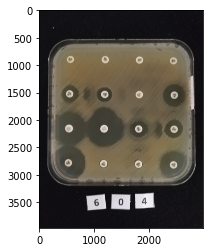

In [3]:
img = imread(img_path)
plt.imshow(img);

### Crop the Petri dish

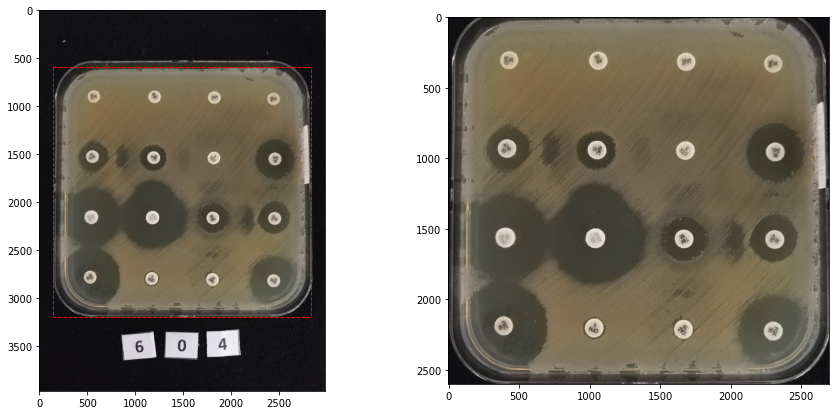

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].imshow(img)
petri = astimp.getPetriDish(img)
draw(petri, axs[0])
axs[1].imshow(petri.img);

### Find and identify antibiotic disks

In [5]:
# Find the positions of the antibiotic disks in the image

crop = petri.img
circles = astimp.find_atb_pellets(crop)
print("Antibiotic disks found:", len(circles))
print()

i=0
print("disk",i)
print("- center:", circles[i].center)
print("- radius:", circles[i].radius)

# calculate the image scale
print()
print(f"image scale: {astimp.get_mm_per_px(circles):.2f} mm/px" )

Antibiotic disks found: 16

disk 0
- center: (2303.36376953125, 2224.565185546875)
- radius: 67.19107055664062

image scale: 0.04 mm/px


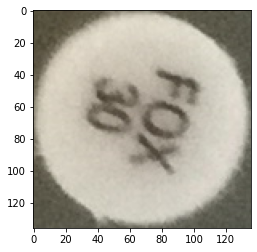

In [6]:
# Extract the sub-image of one pellet

pellets = [astimp.cutOnePelletInImage(crop, circle) for circle in circles]
plt.imshow(pellets[0]);

In [7]:
# Get the antibiotic labels

labels = [astimp.getOnePelletText(pellet) for pellet in pellets]
print("label", labels[0].text, f"score = {labels[0].confidence:.3f}")

label FOX30 score = 1.000


In [8]:
# Print all found labels

preproc = astimp.inhib_diam_preprocessing(petri, circles)
disks = astimp.measureDiameters(preproc)
print("Inhibition diameters")
for label, disk in zip(labels,disks):
    print(f"{label.text}:\t{disk.diameter:.0f}")

Inhibition diameters
FOX30:	22
CAZ10:	6
CFM5:	6
FEC40:	27
FEP30:	14
TIM85:	13
ETP10:	29
IPM10:	27
TPZ36:	18
CTX5:	6
AMC30:	11
ATM30:	13
PRL30:	6
TIC75:	6
AX20:	6
CFR30:	6


---

# Analysis with the AST object
The AST objects can be used to run the whole analysis at once

scale of the image: 22 px/mm


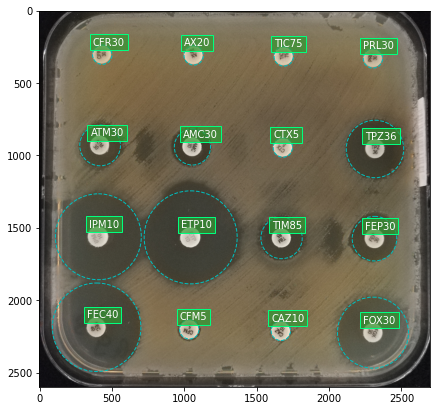

In [14]:
plt.figure(figsize=(7,7))
ast = astimp.AST(img)

# Draw the AST and the measurements
# the atb_labels parameter can be set to 'atb', 'number', 'all', or 'off'
draw(ast, atb_labels='atb')
# print the image scale
print(f"scale of the image: {ast.px_per_mm:.0f} px/mm")

The AST object stores all the measured information

In [15]:
print("Inhibition diameters")
for i in range(len(ast.circles)):
    print(f"{ast.labels[i].text}:\t{ast.inhibitions[i].diameter:.0f}")

Inhibition diameters
FOX30:	22
CAZ10:	6
CFM5:	6
FEC40:	27
FEP30:	14
TIM85:	13
ETP10:	29
IPM10:	27
TPZ36:	18
CTX5:	6
AMC30:	11
ATM30:	13
PRL30:	6
TIC75:	6
AX20:	6
CFR30:	6


# Accessing single antibiotic data

The data of each antibiotic can be accessed as properties of the AST object.

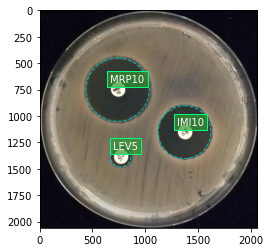

In [27]:
path = "../../tests/images/test_circle.jpg"
img = imread(path)  # load image

ast = astimp.AST(img)
draw(ast, atb_labels='atb')

ATB : LEV5, inhibition diameter: 8.6mm


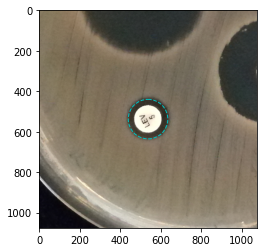

In [20]:
# Print the first antibiotic disk

idx = 0
atb = ast.get_atb_by_idx(idx)
print(atb)
draw(atb)

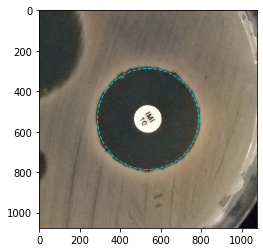

In [21]:
# Get an antibiotic by its label

try:
  name = "IMI10"
  idx = ast.get_atb_idx_by_name(name)
  atb = ast.get_atb_by_idx(idx)
  draw(atb)
except:
  print("{} not found".format(name))

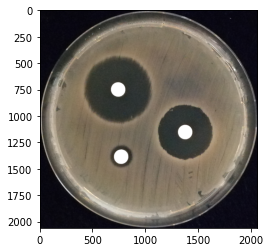

In [22]:
# The module includes other functions that might be useful.
# For example there is one which erases antibiotic labels

plt.imshow(astimp_tools.image.mask_pellets_in_ast_image(ast,all=True));

# Regions Of Interest

ROIs are regions that include only one antibiotic disk.

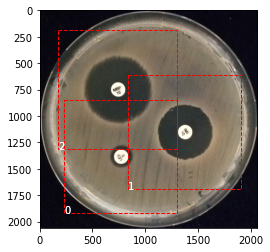

In [23]:
# Plot all the ROIs found in the plate

plt.imshow(ast.crop)
for idx,roi in enumerate(ast.rois):
  draw(roi, text=idx)

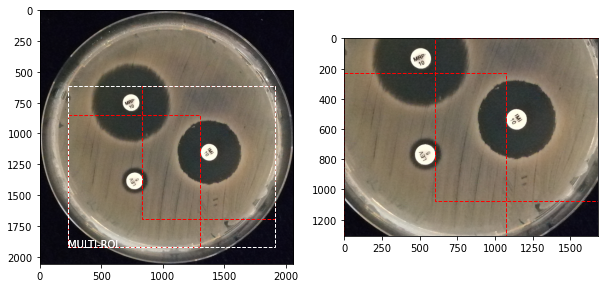

In [24]:
# ROIs support arithmetic sum

plt.figure(figsize=(10,5))

# The sum of ROIs is a ROI
roi = ast.rois[0] + ast.rois[1]

# Draw single rois
plt.subplot(1,2,1)
plt.imshow(ast.crop)
for sub_ROI in roi.abs_sub_ROIs:
  draw(sub_ROI)

draw(roi, text='MULTI-ROI', ec="w")

# Plot the region in the white ROI, which includes both red ones
plt.subplot(1,2,2)
plt.imshow(astimp_tools.image.subimage_by_roi(ast.crop,roi))

# Plot the red subrois
for subroi in roi.sub_ROIs:
    draw(subroi)

---

# Alternative antibiotic disk detection

Antibiotic disks can be missed by the automatic analysis.

Here is a way to find a disk by the approximative coordinates of its center.

For example, This function could be called when the users click on the unidentified antibiotic disk.

In [26]:
img_path = "../../tests/images/test0.jpg"
img = imread(img_path) #load image

crop = astimp.getPetriDish(img).img  # crop Petri Dish
circles = astimp.find_atb_pellets(crop)  # find antibiotic disks
mm_per_px = astimp.get_mm_per_px(circles) # get the image scale

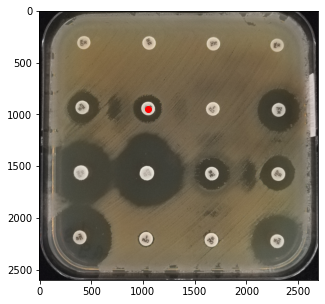

In [55]:
# Identiy the center coordinates of the antibiotic disk
# by drawing a red dot on it

plt.figure(figsize=(5,5))

plt.imshow(crop)
x = 1050 # disk center x-coordinate
y = 950 # disk center y-coodrinate
plt.plot(x,y,'or');

real center: (1055.5, 942.5) radius 66.30000305175781


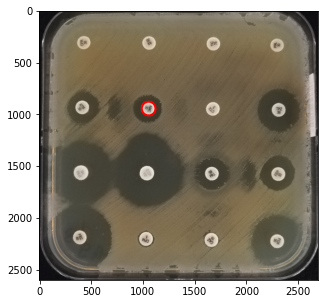

In [56]:
# Detect the pellet real center and radius

plt.figure(figsize=(5,5))

c = astimp.searchOnePellet(crop,x,y,mm_per_px)

print("real center:", c.center, "radius", c.radius)
ax = plt.gca()
plt.imshow(crop, cmap='gray')
cx,cy = c.center
r = c.radius
c = plt.Circle((cx,cy),r, ec='r', lw=2, fc=None, fill=False)
ax.add_artist(c);